In [1]:
import pandas as pd 
import numpy as np
import os

In [2]:
files = os.listdir('../matches')

In [ ]:
import os
import io
import tempfile
import shutil
from typing import Optional, Dict, List, Tuple
import numpy as np
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed


def _sample_file_to_temp(
    in_path: str,
    frac: float,
    rename_cols: Optional[Dict[str, str]],
    seed: int,
    tmpdir: str,
    read_csv_kwargs: Optional[Dict] = None,
) -> Tuple[str, int]:
    """
    Worker: read one CSV, Bernoulli-sample rows, write to a temporary CSV (with header),
    and return (temp_path, n_rows_written). If no rows selected, returns ("", 0).
    """
    if read_csv_kwargs is None:
        read_csv_kwargs = {}

    rng = np.random.default_rng(seed)
    df = pd.read_csv(in_path, **read_csv_kwargs)
    if rename_cols:
        df = df.rename(columns=rename_cols)

    if len(df) == 0:
        return ("", 0)

    mask = rng.random(len(df)) < frac
    sampled = df.loc[mask]
    if sampled.empty:
        return ("", 0)

    fd, tmp_path = tempfile.mkstemp(suffix=".csv", dir=tmpdir)
    os.close(fd)  # we'll open it via pandas
    sampled.to_csv(tmp_path, index=False)  # writes header + data
    return (tmp_path, len(sampled))


def _append_file_skipping_header(src_path: str, dst_fh):
    """
    Append `src_path` CSV to already-open destination file handle `dst_fh`,
    skipping the first line (header) in src.
    """
    with open(src_path, "rb") as sf:
        # Skip first line (header)
        _ = sf.readline()
        # Stream copy the rest
        shutil.copyfileobj(sf, dst_fh)


def sample_from_csv_folder_parallel(
    folder: str,
    frac: float = 1,
    rename_cols: Optional[Dict[str, str]] = None,
    random_state: int = 42,
    max_workers: int = 4,
    out_csv: str = "sampled.csv",
    read_csv_kwargs: Optional[Dict] = None,
) -> str:
    """
    Truly parallel sampling across CSV files:
      - Each worker samples one input CSV and writes to its own temp CSV (header included).
      - Main process merges all temp CSVs into `out_csv` by streaming bytes:
          writes header once, appends the rest skipping headers.

    Memory profile:
      - Each worker holds only one file's DataFrame.
      - Main process never loads DataFrames; it only streams temp files to the final file.

    Returns
    -------
    str
        Path to the final concatenated CSV.
    """
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".csv")]
    if not files:
        # ensure an empty output exists
        open(out_csv, "w").close()
        return out_csv

    if os.path.exists(out_csv):
        os.remove(out_csv)

    tmpdir = tempfile.mkdtemp(prefix="csv_parts_")
    part_paths: List[str] = []
    non_empty_parts: List[Tuple[str, int]] = []

    try:
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            futures = {
                ex.submit(
                    _sample_file_to_temp,
                    path,
                    frac,
                    rename_cols,
                    random_state + i,  # different seed per file
                    tmpdir,
                    read_csv_kwargs,
                ): path
                for i, path in enumerate(files)
            }

            for fut in tqdm(as_completed(futures), total=len(futures), desc="Sampling (parallel)"):
                tmp_path, n_rows = fut.result()
                if n_rows > 0 and tmp_path:
                    non_empty_parts.append((tmp_path, n_rows))

        if not non_empty_parts:
            # no sampled rows at all
            open(out_csv, "w").close()
            return out_csv

        # Merge parts: write header from the first non-empty, append bodies from the rest
        # Sort optional: not required, but keeps deterministic order if desired
        # non_empty_parts.sort(key=lambda t: t[0])

        first_part = non_empty_parts[0][0]
        # Write header + body of first part
        with open(out_csv, "wb") as out_fh:
            with open(first_part, "rb") as fp:
                shutil.copyfileobj(fp, out_fh)  # includes header

            # Append remaining parts skipping header
            for part_path, _ in non_empty_parts[1:]:
                _append_file_skipping_header(part_path, out_fh)

    finally:
        # Clean up temp files
        try:
            shutil.rmtree(tmpdir)
        except Exception:
            pass

    return out_csv

In [6]:
df = sample_from_csv_folder_parallel('../matches', frac=0.7, rename_cols={'gaia_parallax': 'parallax'})

Sampling (parallel):  86%|████████▌ | 2049/2394 [07:12<01:06,  5.19it/s]/tmp/ipykernel_48712/663393449.py:28: DtypeWarning: Columns (179) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(in_path, **read_csv_kwargs)
Sampling (parallel): 100%|██████████| 2394/2394 [08:31<00:00,  4.68it/s]


In [3]:
import pandas as pd

dtypes = {"ra": "float32", "dec": "float32", "parallax": "float32"}
df = pd.read_csv(
    "../data/all_0.7frac.csv",
    engine="pyarrow",
    dtype=dtypes,
    usecols=["ra", "dec", "parallax"]
)

In [4]:
df

ra        dec  parallax
0          18.261957 -22.294117 -2.536971
1          18.448086 -22.293583  0.515212
2          18.365982 -22.293787  3.671753
3          19.067547 -22.289991       NaN
4          18.661663 -22.293074 -0.166435
...              ...        ...       ...
21229334  327.224548 -26.246899 -1.650734
21229335  327.152283 -26.256935       NaN
21229336  326.095673 -26.256973       NaN
21229337  326.914368 -26.226992  0.084915
21229338  327.368042 -26.249668 -0.808297

[21229339 rows x 3 columns]

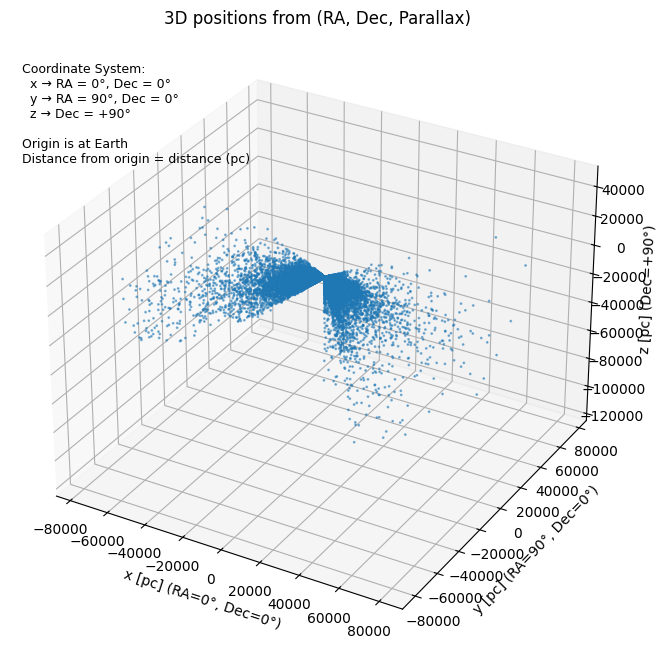

(<Figure size 900x800 with 1 Axes>,
 <Axes3D: title={'center': '3D positions from (RA, Dec, Parallax)'}, xlabel='x [pc] (RA=0°, Dec=0°)', ylabel='y [pc] (RA=90°, Dec=0°)', zlabel='z [pc] (Dec=+90°)'>)

In [5]:
# Re-execute the plotting helper after environment reset.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def plot_3d_from_df(
    data: pd.DataFrame,
    parallax_unit: str = "mas",
    min_parallax: float = 0.0,
    max_distance_pc: float | None = None,
    clip_percentile: float = 99.5,
    sample_max: int | None = 200_000,
    show_legend: bool = True
):
    """
    Make a physically meaningful 3D plot from a catalog with ra, dec, parallax.
    """
    df = data.copy()
    required = {"ra", "dec", "parallax"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ra", "dec", "parallax"])
    if min_parallax is None:
        min_parallax = 0.0
    df = df[df["parallax"] > float(min_parallax)]
    if df.empty:
        raise ValueError("No rows left after filtering invalid/negative parallaxes.")

    # Convert to distance
    if parallax_unit.lower() == "mas":
        df["distance_pc"] = 1000.0 / df["parallax"].astype(float)
    elif parallax_unit.lower() == "arcsec":
        df["distance_pc"] = 1.0 / df["parallax"].astype(float)
    else:
        raise ValueError("parallax_unit must be 'mas' or 'arcsec'.")

    if max_distance_pc is not None:
        df = df[df["distance_pc"] <= float(max_distance_pc)]
    else:
        dcap = np.nanpercentile(df["distance_pc"], clip_percentile)
        df = df[df["distance_pc"] <= dcap]
    if df.empty:
        raise ValueError("No rows left after distance clipping.")

    if sample_max is not None and len(df) > sample_max:
        df = df.sample(sample_max, random_state=42)

    ra_rad = np.deg2rad(df["ra"].astype(float).to_numpy())
    dec_rad = np.deg2rad(df["dec"].astype(float).to_numpy())
    d_pc = df["distance_pc"].to_numpy()

    x = d_pc * np.cos(dec_rad) * np.cos(ra_rad)
    y = d_pc * np.cos(dec_rad) * np.sin(ra_rad)
    z = d_pc * np.sin(dec_rad)

    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, s=1, alpha=0.5)

    ax.set_xlabel("x [pc] (RA=0°, Dec=0°)")
    ax.set_ylabel("y [pc] (RA=90°, Dec=0°)")
    ax.set_zlabel("z [pc] (Dec=+90°)")
    ax.set_title("3D positions from (RA, Dec, Parallax)")

    # Equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5 * max_range
    for axis, center in zip((ax.set_xlim, ax.set_ylim, ax.set_zlim),
                            ((x.max()+x.min())/2, (y.max()+y.min())/2, (z.max()+z.min())/2)):
        axis(center - Xb, center + Xb)

    # Optional legend text in plot
    if show_legend:
        legend_text = (
            "Coordinate System:\n"
            "  x → RA = 0°, Dec = 0°\n"
            "  y → RA = 90°, Dec = 0°\n"
            "  z → Dec = +90°\n\n"
            "Origin is at Earth\n"
            "Distance from origin = distance (pc)"
        )
        ax.text2D(0.02, 0.95, legend_text, transform=ax.transAxes, fontsize=9, va='top', ha='left')

    plt.show()
    return fig, ax


plot_3d_from_df(df)

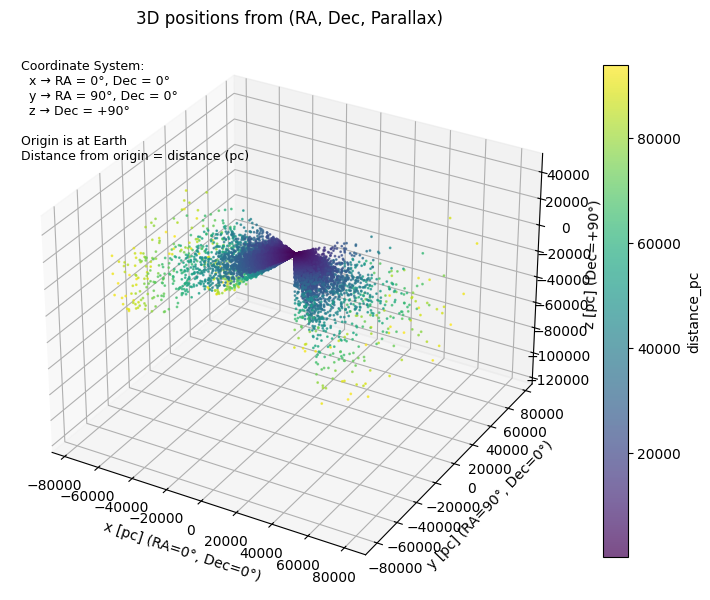

(<Figure size 900x800 with 2 Axes>,
 <Axes3D: title={'center': '3D positions from (RA, Dec, Parallax)'}, xlabel='x [pc] (RA=0°, Dec=0°)', ylabel='y [pc] (RA=90°, Dec=0°)', zlabel='z [pc] (Dec=+90°)'>)

In [10]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def plot_3d_from_df(
    data: pd.DataFrame,
    parallax_unit: str = "mas",
    min_parallax: float = 0.0,
    max_distance_pc: float | None = None,
    clip_percentile: float = 99.5,
    sample_max: int | None = 200_000,
    color_by: str = "distance_pc",
    cmap: str = "viridis",
    show_colorbar: bool = True,
    show_legend: bool = True
):
    """
    Make a 3D plot from (RA, Dec, Parallax) with color gradient.

    Parameters
    ----------
    color_by : str
        Column name or 'distance_pc' to color by.
    cmap : str
        Matplotlib colormap name.
    """
    df = data.copy()
    required = {"ra", "dec", "parallax"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["ra", "dec", "parallax"])
    df = df[df["parallax"] > float(min_parallax)]
    if df.empty:
        raise ValueError("No rows left after filtering invalid/negative parallaxes.")

    # Convert to distance
    if parallax_unit.lower() == "mas":
        df["distance_pc"] = 1000.0 / df["parallax"].astype(float)
    elif parallax_unit.lower() == "arcsec":
        df["distance_pc"] = 1.0 / df["parallax"].astype(float)
    else:
        raise ValueError("parallax_unit must be 'mas' or 'arcsec'.")

    if max_distance_pc is not None:
        df = df[df["distance_pc"] <= float(max_distance_pc)]
    else:
        dcap = np.nanpercentile(df["distance_pc"], clip_percentile)
        df = df[df["distance_pc"] <= dcap]
    if df.empty:
        raise ValueError("No rows left after distance clipping.")

    if sample_max is not None and len(df) > sample_max:
        df = df.sample(sample_max, random_state=42)

    ra_rad = np.deg2rad(df["ra"].astype(float).to_numpy())
    dec_rad = np.deg2rad(df["dec"].astype(float).to_numpy())
    d_pc = df["distance_pc"].to_numpy()

    x = d_pc * np.cos(dec_rad) * np.cos(ra_rad)
    y = d_pc * np.cos(dec_rad) * np.sin(ra_rad)
    z = d_pc * np.sin(dec_rad)

    # Determine what to color by
    if color_by not in df.columns:
        if color_by == "distance_pc":
            cvals = d_pc
        else:
            raise ValueError(f"Column '{color_by}' not found.")
    else:
        cvals = df[color_by].to_numpy()

    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(x, y, z, s=1, alpha=0.7, c=cvals, cmap=cmap)

    ax.set_xlabel("x [pc] (RA=0°, Dec=0°)")
    ax.set_ylabel("y [pc] (RA=90°, Dec=0°)")
    ax.set_zlabel("z [pc] (Dec=+90°)")
    ax.set_title("3D positions from (RA, Dec, Parallax)")

    # Equal aspect ratio
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
    Xb = 0.5 * max_range
    for axis, center in zip((ax.set_xlim, ax.set_ylim, ax.set_zlim),
                            ((x.max()+x.min())/2, (y.max()+y.min())/2, (z.max()+z.min())/2)):
        axis(center - Xb, center + Xb)

    # Optional colorbar
    if show_colorbar:
        cbar = plt.colorbar(sc, ax=ax, pad=0.05, shrink=0.8)
        cbar.set_label(f"{color_by}")

    # Optional legend text
    if show_legend:
        legend_text = (
            "Coordinate System:\n"
            "  x → RA = 0°, Dec = 0°\n"
            "  y → RA = 90°, Dec = 0°\n"
            "  z → Dec = +90°\n\n"
            "Origin is at Earth\n"
            "Distance from origin = distance (pc)"
        )
        ax.text2D(0.02, 0.95, legend_text, transform=ax.transAxes, fontsize=9, va='top', ha='left')

    plt.show()
    return fig, ax

plot_3d_from_df(df)

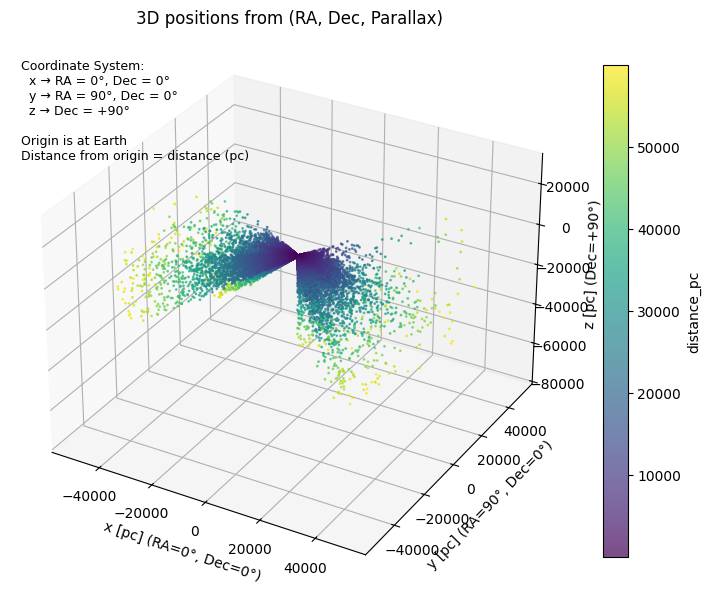

(<Figure size 900x800 with 2 Axes>,
 <Axes3D: title={'center': '3D positions from (RA, Dec, Parallax)'}, xlabel='x [pc] (RA=0°, Dec=0°)', ylabel='y [pc] (RA=90°, Dec=0°)', zlabel='z [pc] (Dec=+90°)'>)

In [8]:
plot_3d_from_df(df, max_distance_pc=1000 * 60)  # or any value you want

In [13]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def plot3d_plotly(
    df: pd.DataFrame,
    parallax_unit: str = "mas",
    color_by: str = "distance_pc",
    clip_percentile: float = 99.5,
    max_distance_pc: float | None = None,
    sample_max: int | None = 200_000,
    point_size: float = 2.0,
    opacity: float = 0.7,
    title: str = "3D positions from (RA, Dec, Parallax)"
):
    # basic checks
    req = {"ra", "dec", "parallax"}
    if not req.issubset(df.columns):
        missing = req - set(df.columns)
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # copy and clean
    d = df[["ra", "dec", "parallax"]].copy()
    d = d.replace([np.inf, -np.inf], np.nan).dropna()
    d = d[d["parallax"] > 0]

    # distance in parsec
    if parallax_unit.lower() == "mas":
        d["distance_pc"] = 1000.0 / d["parallax"].astype(float)
    elif parallax_unit.lower() == "arcsec":
        d["distance_pc"] = 1.0 / d["parallax"].astype(float)
    else:
        raise ValueError("parallax_unit must be 'mas' or 'arcsec'.")

    # limit extreme distances
    if max_distance_pc is not None:
        d = d[d["distance_pc"] <= float(max_distance_pc)]
    elif clip_percentile is not None:
        cap = np.nanpercentile(d["distance_pc"], clip_percentile)
        d = d[d["distance_pc"] <= cap]

    if d.empty:
        raise ValueError("No rows left after filtering/clipping distances.")

    # optional downsampling for performance
    if sample_max is not None and len(d) > sample_max:
        d = d.sample(sample_max, random_state=42)

    # convert to 3D Cartesian (equatorial frame; units in pc)
    ra_rad  = np.deg2rad(d["ra"].astype(float).to_numpy())
    dec_rad = np.deg2rad(d["dec"].astype(float).to_numpy())
    dist    = d["distance_pc"].astype("float32").to_numpy()

    x = dist * np.cos(dec_rad) * np.cos(ra_rad)
    y = dist * np.cos(dec_rad) * np.sin(ra_rad)
    z = dist * np.sin(dec_rad)

    # choose color values
    if color_by == "distance_pc":
        cvals = dist
        ctitle = "distance_pc"
    else:
        if color_by not in df.columns:
            raise ValueError(f"Column '{color_by}' not found in DataFrame.")
        cvals = df.loc[d.index, color_by].to_numpy()
        ctitle = color_by

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=x, y=y, z=z,
                mode="markers",
                marker=dict(
                    size=point_size,
                    opacity=opacity,
                    color=cvals,
                    colorscale="Viridis",
                    colorbar=dict(title=ctitle)
                ),
                hovertemplate="x=%{x:.1f} pc<br>y=%{y:.1f} pc<br>z=%{z:.1f} pc<br>"
                              f"{ctitle}=%{{marker.color:.2f}}<extra></extra>"
            )
        ]
    )

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="x [pc] (RA=0°, Dec=0°)",
            yaxis_title="y [pc] (RA=90°, Dec=0°)",
            zaxis_title="z [pc] (Dec=+90°)",
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    return fig

In [14]:
# Color by distance (default), clip extreme distances at 99.5th percentile,
# and plot up to 200k points for smooth interaction.
fig = plot3d_plotly(df, parallax_unit="mas", clip_percentile=99.5, sample_max=200_000)
fig.show()

In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dtypes = {
    "id": "string",
    "ra": "float32",
    "dec": "float32",
    "parallax": "float32",
    "gaia_ruwe": "float32",
    "gaia_parallax_over_error": "float32",
    "gaia_classprob_dsc_combmod_star": "float32",
    "gaia_in_qso_candidates": "int8",
    "gaia_in_galaxy_candidates": "int8",
    "gaia_phot_bp_rp_excess_factor": "float32",
    "mag_pstotal_r": "float32",
    "mag_pstotal_i": "float32",
    "mag_pstotal_u": "float32",
    "mag_pstotal_g": "float32",
    "mag_pstotal_z": "float32",
    "mag_pstotal_j0378": "float32",
    "mag_pstotal_j0395": "float32",
    "mag_pstotal_j0410": "float32",
    "mag_pstotal_j0430": "float32",
    "mag_pstotal_j0515": "float32",
    "mag_pstotal_j0660": "float32",
    "mag_pstotal_j0861": "float32",
    "err_mag_pstotal_r": "float32",
    "err_mag_pstotal_i": "float32",
    "err_mag_pstotal_u": "float32",
    "err_mag_pstotal_g": "float32",
    "err_mag_pstotal_z": "float32",
    "err_mag_pstotal_j0378": "float32",
    "err_mag_pstotal_j0395": "float32",
    "err_mag_pstotal_j0410": "float32",
    "err_mag_pstotal_j0430": "float32",
    "err_mag_pstotal_j0515": "float32",
    "err_mag_pstotal_j0660": "float32",
    "err_mag_pstotal_j0861": "float32",
}

df = pd.read_csv(
    "../data/all_0.7frac.csv",
    engine="pyarrow",
    dtype=dtypes,
    usecols=list(dtypes.keys())
)

In [105]:
df = df[(df['mag_pstotal_r'] > 12) & (df['mag_pstotal_r'] < 22)]

In [6]:
import numpy as np
import pandas as pd

# ---------- Configuration ----------
W_nb_J0660 = 147.0  # Å, S-PLUS J0660 effective width
LAMBDA = {
    'u': 3536.0, 'J0378': 3770.0, 'J0395': 3940.0, 'J0410': 4094.0, 'J0430': 4292.0,
    'g': 4751.0, 'J0515': 5133.0, 'r': 6258.0, 'J0660': 6614.0, 'i': 7690.0,
    'J0861': 8611.0, 'z': 8831.0
}
LAM_HA = 6563.0

# Bands to use for continuum fit (exclude the Hα narrow-band!)
CONTINUUM_BANDS = ['u','J0378','J0395','J0410','J0430','g','J0515','r','i','J0861','z']

# Column name templates from your DataFrame
MAG_COL = {
    'u': 'mag_pstotal_u',   'g': 'mag_pstotal_g',   'r': 'mag_pstotal_r',   'i': 'mag_pstotal_i',   'z': 'mag_pstotal_z',
    'J0378': 'mag_pstotal_j0378', 'J0395': 'mag_pstotal_j0395', 'J0410': 'mag_pstotal_j0410',
    'J0430': 'mag_pstotal_j0430', 'J0515': 'mag_pstotal_j0515', 'J0660': 'mag_pstotal_j0660', 'J0861': 'mag_pstotal_j0861'
}
ERR_COL = {
    'u': 'err_mag_pstotal_u','g': 'err_mag_pstotal_g','r': 'err_mag_pstotal_r','i': 'err_mag_pstotal_i','z': 'err_mag_pstotal_z',
    'J0378': 'err_mag_pstotal_j0378','J0395': 'err_mag_pstotal_j0395','J0410': 'err_mag_pstotal_j0410',
    'J0430': 'err_mag_pstotal_j0430','J0515': 'err_mag_pstotal_j0515','J0660': 'err_mag_pstotal_j0660','J0861': 'err_mag_pstotal_j0861'
}

BANDS = ['u','J0378','J0395','J0410','J0430','g','J0515','r','J0660','i','J0861','z']


# ---------- Helpers ----------
def mags_to_flux_ln(m, dm):
    """
    Convert AB magnitudes to natural-log flux (arbitrary units) and its uncertainty.
    ln f = -0.4 * ln(10) * m + C ; sigma_ln f = (ln(10)/2.5) * dm
    The additive constant C cancels in ratios, so we ignore it.
    """
    k = np.log(10)/2.5
    ln_f = -0.4*np.log(10)*m
    s_ln_f = k*dm
    return ln_f, s_ln_f

def weighted_poly_fit_lnflux(lam, ln_f, s_ln_f, lam0=LAM_HA, deg=2, max_iter=3, sigma_clip=3.0):
    """
    Fit ln(f) = beta0 + beta1*t + beta2*t^2 (deg=2) with weights 1/sigma^2, where t = (lam - lam0)/1000.
    Iterative sigma-clipping on residuals in ln(f).
    Returns beta, Cov(beta), mask_used (bool array), and a flag 'ok'.
    """
    lam = np.asarray(lam); ln_f = np.asarray(ln_f); s_ln_f = np.asarray(s_ln_f)
    t = (lam - lam0)/1000.0
    Xfull = np.vstack([np.ones_like(t), t, t**2 if deg >= 2 else np.zeros_like(t)]).T[:, :deg+1]

    mask = np.isfinite(ln_f) & np.isfinite(s_ln_f) & np.isfinite(t) & (s_ln_f > 0)
    ok = False
    beta = None; Cov = None

    for _ in range(max_iter):
        if mask.sum() < (deg+2):  # need at least deg+2 points for a stable fit
            break
        X = Xfull[mask]
        y = ln_f[mask]
        w = 1.0 / (s_ln_f[mask]**2)
        # Weighted least squares: (X^T W X) beta = X^T W y
        XT_W = X.T * w
        A = XT_W @ X
        b = XT_W @ y
        try:
            beta = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            break

        # Residuals and robust sigma
        yhat = X @ beta
        res = y - yhat
        # Weighted residual variance estimate
        dof = max(1, mask.sum() - (deg+1))
        s2 = (w * res**2).sum() / w.sum()  # conservative
        s = np.sqrt(s2)
        new_mask = mask.copy()
        # sigma-clip on absolute residuals in ln(f)
        new_mask[np.where(mask)[0][np.abs(res) > sigma_clip * s]] = False
        if new_mask.sum() == mask.sum():
            # Converged — compute covariance with classic WLS formula
            # Use unweighted residual variance estimate s2_hat:
            s2_hat = (res**2).sum() / dof
            Cov = np.linalg.inv(A) * s2_hat
            ok = True
            break
        mask = new_mask

    return beta, Cov, mask, ok

def predict_lnflux_at(beta, Cov, lam_eval, lam0=LAM_HA):
    """Predict ln(f) and its variance at lam_eval from polynomial coefficients."""
    t0 = (lam_eval - lam0)/1000.0
    # Feature vector x0
    x0 = np.array([1.0, t0, t0**2])
    x0 = x0[:len(beta)]
    ln_f_hat = float(x0 @ beta)
    var_ln_f_hat = float(x0 @ Cov @ x0)
    return ln_f_hat, var_ln_f_hat

def ew_from_fluxes(f_nb, df_nb, f_c, df_c, W_nb=W_nb_J0660):
    R = f_nb / f_c
    dR = R * np.sqrt((df_nb/np.maximum(f_nb, 1e-300))**2 + (df_c/np.maximum(f_c, 1e-300))**2)
    EW = W_nb * (R - 1.0)
    dEW = W_nb * dR
    return EW, dEW

def ri_fallback(df_row):
    """Robust r–i linear interpolation fallback in flux (not ln-flux)."""
    # flux and errors (linear space) for r, i, J0660
    def mag_to_flux(m, dm):
        f = 10**(-0.4*m)
        df = (np.log(10)/2.5) * f * dm
        return f, df

    fr, dfr = mag_to_flux(df_row[MAG_COL['r']],  df_row[ERR_COL['r']])
    fi, dfi = mag_to_flux(df_row[MAG_COL['i']],  df_row[ERR_COL['i']])
    fnb, dfnb = mag_to_flux(df_row[MAG_COL['J0660']], df_row[ERR_COL['J0660']])

    lam_r, lam_i = LAMBDA['r'], LAMBDA['i']
    wr = (lam_i - LAM_HA) / (lam_i - lam_r)
    wi = 1.0 - wr
    fc = wr*fr + wi*fi
    dfc = np.sqrt((wr*dfr)**2 + (wi*dfi)**2)

    EW, dEW = ew_from_fluxes(fnb, dfnb, fc, dfc)
    snr = EW / np.maximum(dEW, 1e-30)
    return EW, dEW, snr

# ---------- Main function ----------
def detect_halpha_emitters(df,
                           ew_min=10.0, snr_min=3.0,
                           deg=2, max_iter=3, sigma_clip=3.0):
    """
    Compute EW(Hα) from S-PLUS photometry with a continuum fit (excluding J0660).
    Falls back to r–i interpolation if WLS fit is not possible for a source.

    Returns:
      results: DataFrame with ['EW_Ha','EW_Ha_err','SNR_EW','method'] aligned to df.index
      mask_emitters: boolean Series where selection passes (EW>ew_min & SNR>=snr_min)
    """
    # Pre-extract arrays for speed
    # ln-flux and uncertainties for all bands we use
    lnF = {}
    s_lnF = {}
    for b in CONTINUUM_BANDS + ['J0660']:
        m = df[MAG_COL[b]].values.astype(float)
        dm = df[ERR_COL[b]].values.astype(float)
        lnF[b], s_lnF[b] = mags_to_flux_ln(m, dm)

    # Build per-row arrays for continuum bands
    lam_all = np.array([LAMBDA[b] for b in CONTINUUM_BANDS], dtype=float)
    lnF_all = np.vstack([lnF[b] for b in CONTINUUM_BANDS]).T
    s_lnF_all = np.vstack([s_lnF[b] for b in CONTINUUM_BANDS]).T

    # J0660 (narrow-band)
    lnF_nb = lnF['J0660']
    s_lnF_nb = s_lnF['J0660']

    N = len(df)
    EW = np.full(N, np.nan)
    dEW = np.full(N, np.nan)
    SNR = np.full(N, np.nan)
    method = np.empty(N, dtype=object)

    # Per-object fit
    for i in range(N):
        lam = lam_all.copy()
        ln_f = lnF_all[i].copy()
        s_ln_f = s_lnF_all[i].copy()

        # Drop any NaNs per-row
        ok_mask = np.isfinite(ln_f) & np.isfinite(s_ln_f)
        lam_i = lam[ok_mask]; ln_f_i = ln_f[ok_mask]; s_ln_f_i = s_ln_f[ok_mask]

        beta, Cov, used_mask, ok = weighted_poly_fit_lnflux(
            lam_i, ln_f_i, s_ln_f_i, lam0=LAM_HA, deg=deg, max_iter=max_iter, sigma_clip=sigma_clip
        )

        # Narrow-band in linear flux:
        # f_nb = exp(ln f), df_nb via error in ln(f): sigma_f = f * sigma_ln f
        f_nb = np.exp(lnF_nb[i])
        df_nb = f_nb * s_lnF_nb[i]

        if ok:
            ln_fc, var_ln_fc = predict_lnflux_at(beta, Cov, LAM_HA, lam0=LAM_HA)
            f_c = np.exp(ln_fc)
            df_c = f_c * np.sqrt(max(var_ln_fc, 0.0))
            EW[i], dEW[i] = ew_from_fluxes(f_nb, df_nb, f_c, df_c, W_nb=W_nb_J0660)
            SNR[i] = EW[i]/np.maximum(dEW[i], 1e-30)
            method[i] = 'WLS-continuum'
        else:
            # Fallback to r-i interpolation
            ew_fb, dew_fb, snr_fb = ri_fallback(df.iloc[i])
            EW[i], dEW[i], SNR[i] = ew_fb, dew_fb, snr_fb
            method[i] = 'r-i-fallback'

    results = pd.DataFrame({
        'EW_Ha': EW,
        'EW_Ha_err': dEW,
        'SNR_EW': SNR,
        'method': method
    }, index=df.index)

    # Selection
    emitters = (results['EW_Ha'] > ew_min) & (results['SNR_EW'] >= snr_min)

    return results, emitters

# ---------- Example usage ----------
# results, emitters = detect_halpha_emitters(df, ew_min=10.0, snr_min=3.0)
# emitters_df = df[emitters].join(results)

In [ ]:
results, emitters = detect_halpha_emitters(df, ew_min=30.0, snr_min=3.0)

In [ ]:
emitters_df = df[emitters].join(results)

In [ ]:
emitters_df

id          ra        dec  parallax  gaia_ruwe  \
363      b'i06s17s14003CP'   19.333351 -22.120970 -0.099953   1.003264   
897      b'i06s17s14007OD'   18.262680 -21.911612 -0.064293   1.006492   
1296     b'i06s17s1400AO8'   19.515049 -21.771523  1.721920   1.016039   
1507     b'i06s17s1400CUE'   18.249563 -21.688875       NaN        NaN   
1532     b'i06s17s1400D00'   18.451660 -21.677734 -0.250376   1.084852   
...                    ...         ...        ...       ...        ...   
100561  b'i06S820115018NJ'  319.804291  -0.043983  0.076852   1.010501   
100569  b'i06S820115018O4'  320.203827  -0.042080  0.969542   1.075229   
100613  b'i06S820115018TF'  320.018280  -0.034155  0.926671   1.060383   
100614  b'i06S820115018TM'  319.874481  -0.041680  0.178850   1.072779   
100739  b'i06S8201150196S'  319.889954  -0.058961  1.460284   1.261140   

        gaia_parallax_over_error  gaia_classprob_dsc_combmod_star  \
363                    -0.664799                     9.942401e-19   
897                    -0.159906                     2.507606e-02   
1296                    3.902112                     9.999607e-01   
1507                         NaN                     9.793641e-01   
1532                   -0.270370                     9.999974e-01   
...                          ...                              ...   
100561                  0.642803                     9.999590e-01   
100569                  1.502875                     9.999912e-01   
100613                  1.164279                     9.999976e-01   
100614                  0.243200                     9.999959e-01   
100739                  1.399820                     9.999991e-01   

        gaia_in_qso_candidates  gaia_in_galaxy_candidates  \
363                          1                          0   
897                          1                          0   
1296                         0                          0   
1507                         0                          0   
1532                         0                          0   
...                        ...                        ...   
100561                       0                          0   
100569                       0                          0   
100613                       0                          0   
100614                       0                          0   
100739                       0                          0   

        gaia_phot_bp_rp_excess_factor  ...  err_mag_pstotal_j0395  \
363                          1.177458  ...               0.078198   
897                          1.172389  ...               0.702244   
1296                         1.518965  ...                    NaN   
1507                        10.872929  ...               0.261043   
1532                         1.352453  ...               3.456553   
...                               ...  ...                    ...   
100561                       1.183493  ...               0.113219   
100569                       1.666294  ...                    NaN   
100613                       1.271031  ...               0.467985   
100614                       1.336261  ...               4.456779   
100739                       1.805207  ...              44.193398   

        err_mag_pstotal_j0410  err_mag_pstotal_j0430  err_mag_pstotal_j0515  \
363                  0.075430               0.063104               0.050431   
897                  1.095171               0.565074               0.249202   
1296                      NaN               0.878407               0.470036   
1507                 0.279642               0.249586               0.097564   
1532                      NaN               1.017469               1.117463   
...                       ...                    ...                    ...   
100561               0.054692               0.046687               0.028160   
100569               2.168606               2.129501               0.710130   
100613               3.963127    

In [ ]:
emitters_df = emitters_df[emitters_df['mag_pstotal_j0660'] < emitters_df['mag_pstotal_i']]

In [9]:
import pandas as pd

emitters_df = pd.read_csv('../data/halpha_emitters-gustabin/SPLUS-s.csv')

In [10]:
emitters_df

id          ra        dec  parallax  gaia_ruwe  \
0      b'i06s22s02002JF'    1.809939 -28.860859 -6.840524   1.073732   
1      b'i06s22s02005Y6'    1.769118 -28.741034  0.124612   1.070435   
2      b'i06s22s0200A9M'    1.365490 -28.590878       NaN        NaN   
3      b'i06s22s0200I2A'    1.181675 -28.309032  1.544130   1.078350   
4      b'i06s22s0200NSN'    1.816216 -28.130732  0.310271   1.044393   
...                  ...         ...        ...       ...        ...   
26351  b'i06s22s2101N81'  315.443080 -27.724928  0.935013   0.986337   
26352  b'i06s22s2101NAN'  315.521480 -27.757470  0.703376   0.957619   
26353  b'i06s22s2101T2A'  315.119260 -27.653637  0.378671   1.131497   
26354  b'i06s22s2101WG0'  315.171900 -27.540098 -0.591308   0.992140   
26355  b'i06s22s2101WN3'  315.928620 -27.535652  0.838266   0.925273   

       gaia_parallax_over_error  gaia_classprob_dsc_combmod_star  \
0                     -2.972157                         0.994158   
1                      0.284823                         0.999994   
2                           NaN                         0.000000   
3                      0.866476                         0.999996   
4                      0.301320                         0.999992   
...                         ...                              ...   
26351                  0.441604                         0.904383   
26352                 36.758620                         0.999992   
26353                 19.351881                         0.999996   
26354                 -0.457588                         0.999997   
26355                  1.046882                         0.462034   

       gaia_in_qso_candidates  gaia_in_galaxy_candidates  \
0                           0                          0   
1                           0                          0   
2                           0                          1   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
26351                       1                          0   
26352                       0                          0   
26353                       0                          0   
26354                       0                          0   
26355                       1                          0   

       gaia_phot_bp_rp_excess_factor  ...  err_mag_pstotal_j0395  \
0                           1.383870  ...               1.566476   
1                           1.196446  ...               1.560313   
2                          17.321493  ...               0.069405   
3                           1.169682  ...               2.578334   
4                           1.202990  ...               1.408133   
...                              ...  ...                    ...   
26351                       1.409652  ...               0.351324   
26352                       1.245274  ...               0.006555   
26353                       1.249600  ...               0.005958   
26354                       1.179651  ...               0.210036   
26355                       1.315001  ...               0.136238   

       err_mag_pstotal_j0410  err_mag_pstotal_j0430  err_mag_pstotal_j0515  \
0                   0.975727               1.511250               0.469163   
1                   0.431952               1.033411               0.190540   
2                   0.063865               0.051269               0.022556   
3                   4.584225               0.364802               0.705429   
4                  20.446041               0.481102               0.561497   
...                      ...                    ...                    ...   
26351               1.506297               0.689284               0.170986   
26352               0.004191               0.003495               0.001960   
26353               0.003700               0.003194               0.001755   
26354               0.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_splus_sed_mag(df, index, *,
                       max_err=0.30,              # absolute cap in mag (used if cap_mode='absolute')
                       cap_mode='absolute',       # 'absolute' or 'percentile'
                       cap_percentile=90,         # used if cap_mode='percentile'
                       show_capped_arrows=True):  # draw arrows for capped error bars
    """
    Plot the S-PLUS 12-band SED in magnitudes for a single object,
    capping excessively large error bars for visualization.

    Parameters
    ----------
    df : pandas.DataFrame
    index : int or label
    max_err : float
        Absolute cap (mag) when cap_mode='absolute'.
    cap_mode : {'absolute', 'percentile'}
        How to determine the error cap.
    cap_percentile : int
        If cap_mode='percentile', cap = np.nanpercentile(dmags, cap_percentile).
    show_capped_arrows : bool
        If True, draws arrows (uplims+lolims) for the capped points.
    """
    row = df.loc[index]
    lam = np.array([LAMBDA[b] for b in BANDS], dtype=float)

    # Magnitudes and errors
    mags = np.array([row[MAG_COL[b]] for b in BANDS], dtype=float)
    dmags = np.array([row[ERR_COL[b]] for b in BANDS], dtype=float)

    # Basic sanity mask (finite values only)
    finite = np.isfinite(lam) & np.isfinite(mags) & np.isfinite(dmags)
    lam, mags, dmags = lam[finite], mags[finite], dmags[finite]
    bands_used = np.array([b for b in BANDS])[finite]

    # Sort by wavelength
    order = np.argsort(lam)
    lam, mags, dmags = lam[order], mags[order], dmags[order]
    bands_sorted = bands_used[order]

    # Determine cap
    if cap_mode == 'percentile':
        cap_val = float(np.nanpercentile(dmags, cap_percentile))
    else:
        cap_val = float(max_err)

    # Build capped error array
    dm_plot = dmags.copy()
    capped = dmags > cap_val
    dm_plot[capped] = cap_val

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot uncapped points
    mask_uncapped = ~capped
    if mask_uncapped.any():
        ax.errorbar(lam[mask_uncapped], mags[mask_uncapped],
                    yerr=dm_plot[mask_uncapped],
                    fmt='o', capsize=3, color='black', ecolor='gray',
                    label='Bands')

    # Plot capped points (optionally with arrow caps)
    if capped.any():
        if show_capped_arrows:
            ax.errorbar(lam[capped], mags[capped],
                        yerr=dm_plot[capped],
                        fmt='o', capsize=3, color='black', ecolor='gray',
                        uplims=True, lolims=True,  # show arrows to indicate "true error exceeds"
                        label='Bands (capped)')
        else:
            ax.errorbar(lam[capped], mags[capped],
                        yerr=dm_plot[capped],
                        fmt='o', capsize=3, color='black', ecolor='gray',
                        label='Bands (capped)')

    # Highlight J0660 in red (if present after masking)
    if 'J0660' in bands_sorted:
        ha_idx = np.where(bands_sorted == 'J0660')[0][0]
        ax.scatter(lam[ha_idx], mags[ha_idx],
                   color='red', s=70, zorder=5, label='J0660 (Hα)')

    # Annotate band labels
    for i, b in enumerate(bands_sorted):
        ax.text(lam[i], mags[i] - 0.05, b, ha='center', fontsize=8)

    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Magnitude (AB)')
    ax.invert_yaxis()  # lower mag = brighter
    ax.grid(alpha=0.3)

    # Title with ID
    if 'id' in df.columns:
        obj_id = row['id']
        ax.set_title(f'Object ID: {obj_id}', fontsize=12, pad=10)
    else:
        ax.set_title(f'Index: {index}', fontsize=12, pad=10)

    # Build legend (avoid duplicate labels)
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc='best')

    # Footer note if any caps applied
    if capped.any():
        cap_info = f"error bars capped at {cap_val:.2f} mag ({'percentile' if cap_mode=='percentile' else 'absolute'})"
        ax.text(0.99, 0.02, cap_info, transform=ax.transAxes, ha='right', va='bottom',
                fontsize=8, color='dimgray')

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_splus_sed_mag(df, index=0, max_err=0.30, cap_mode='absolute')
# plot_splus_sed_mag(df, index=0, cap_mode='percentile', cap_percentile=85)

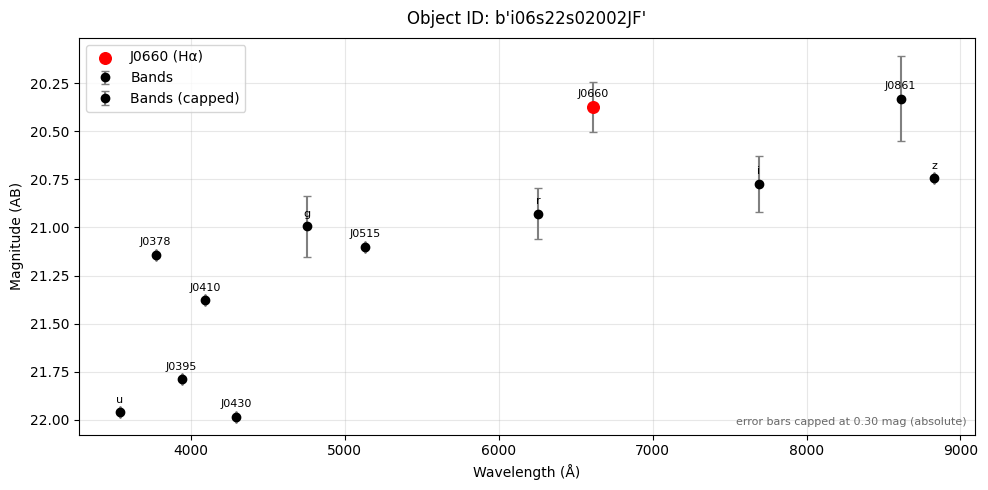

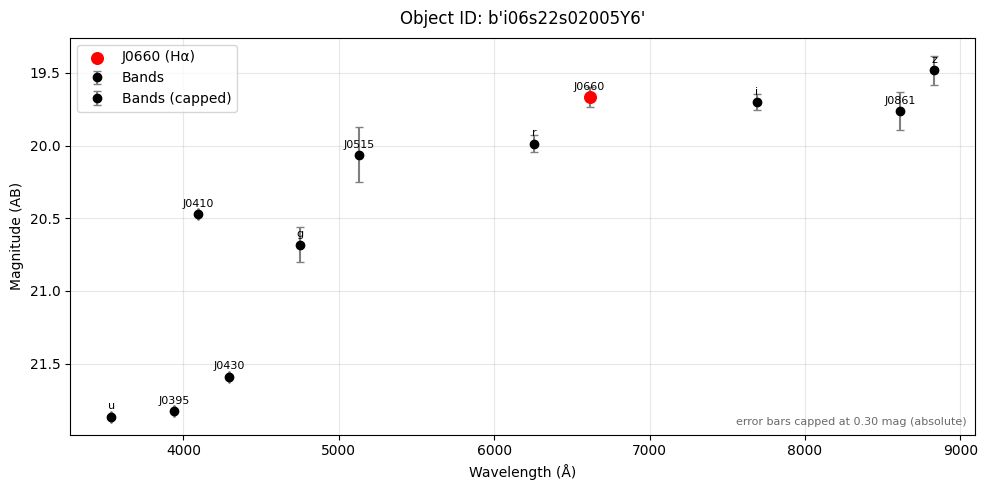

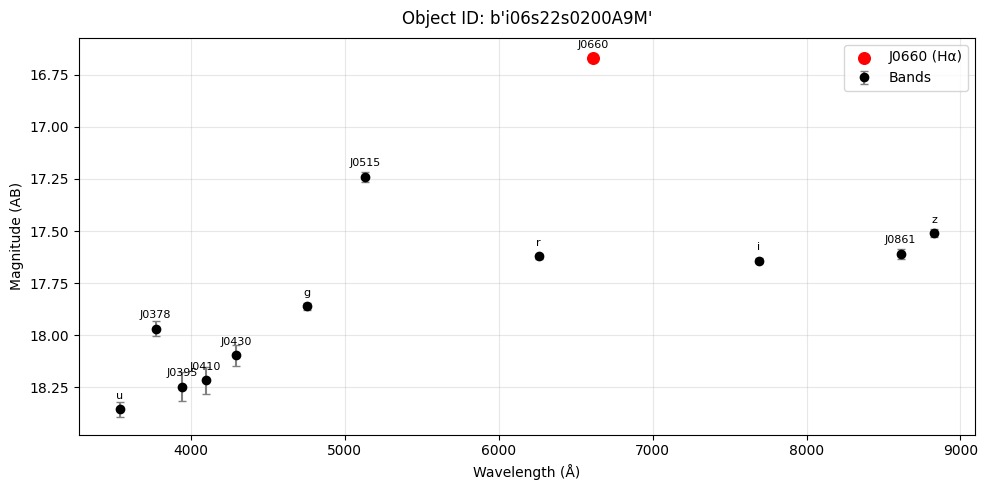

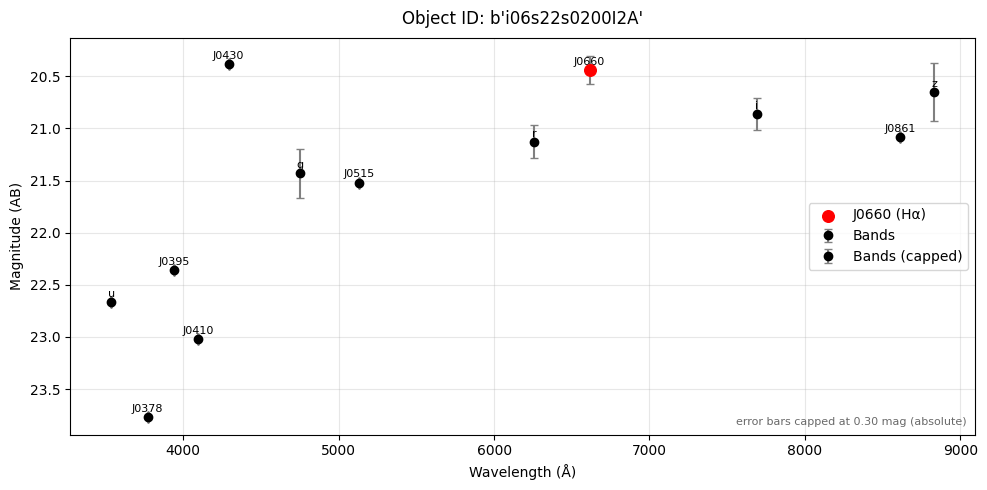

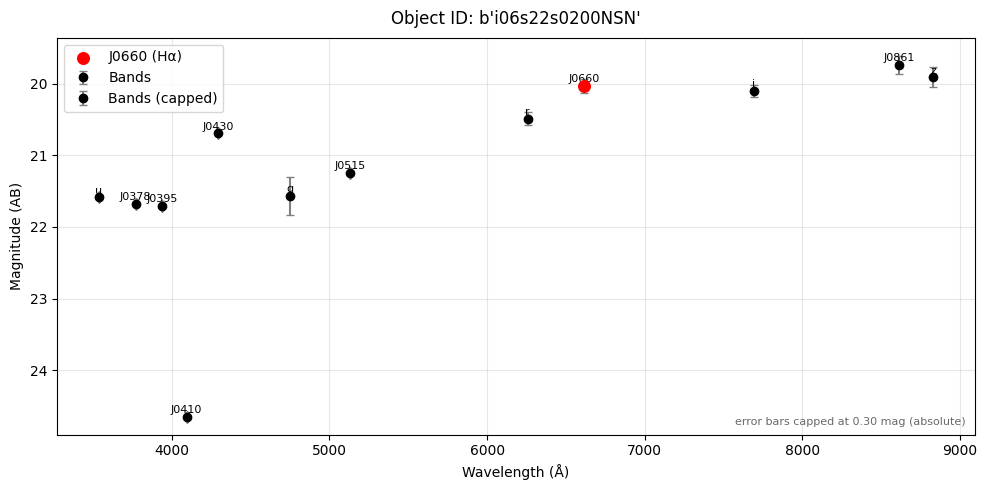

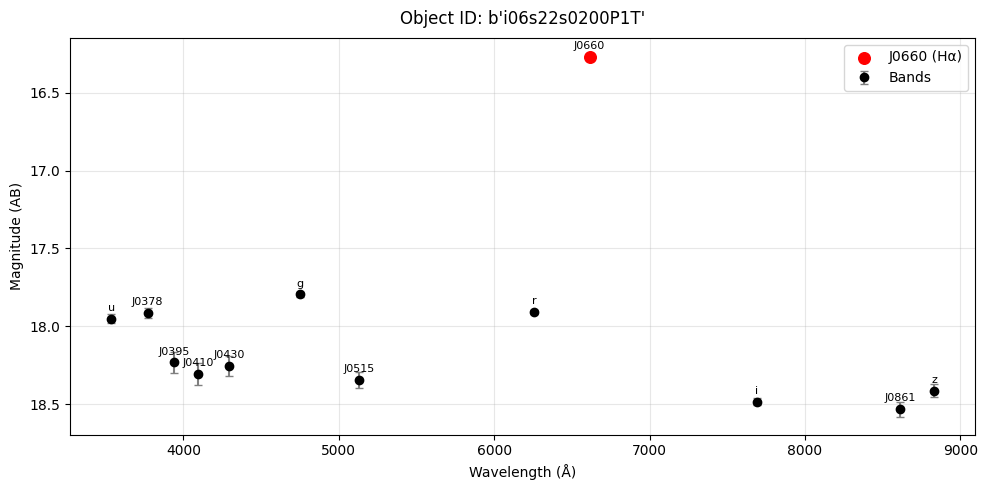

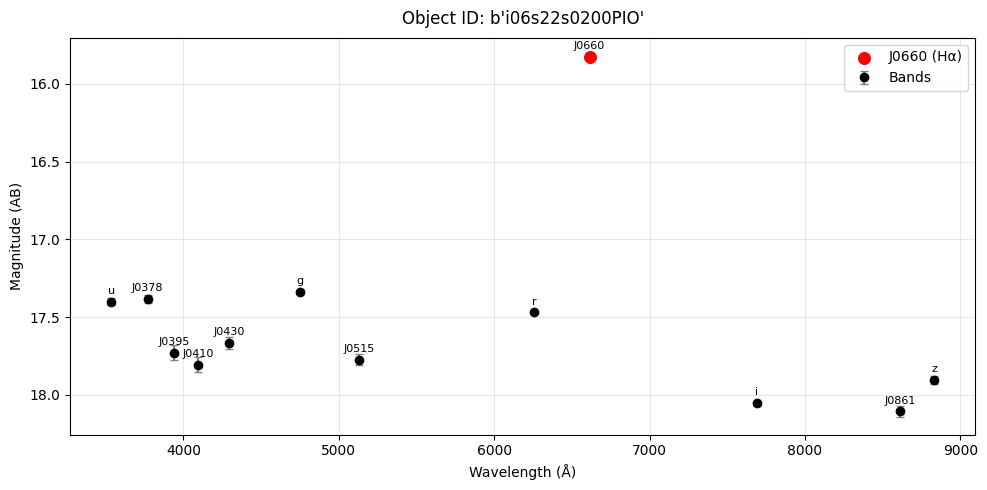

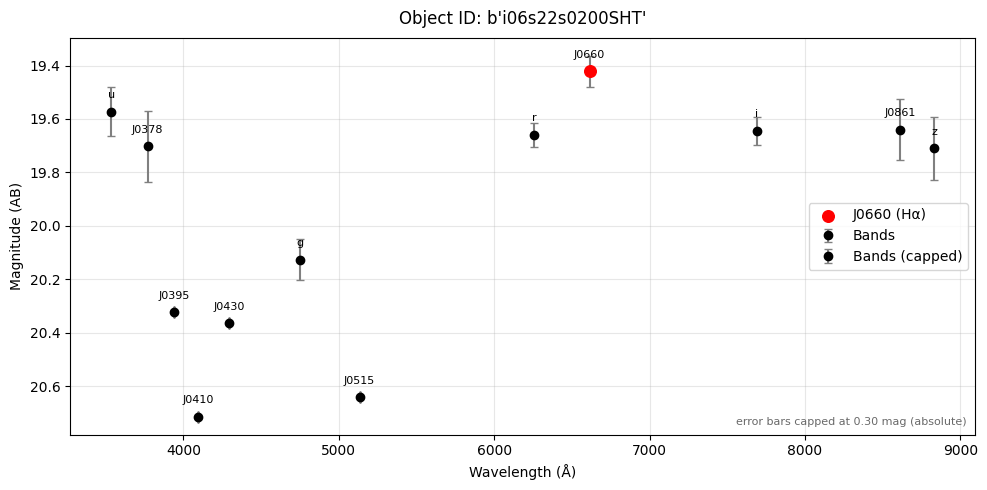

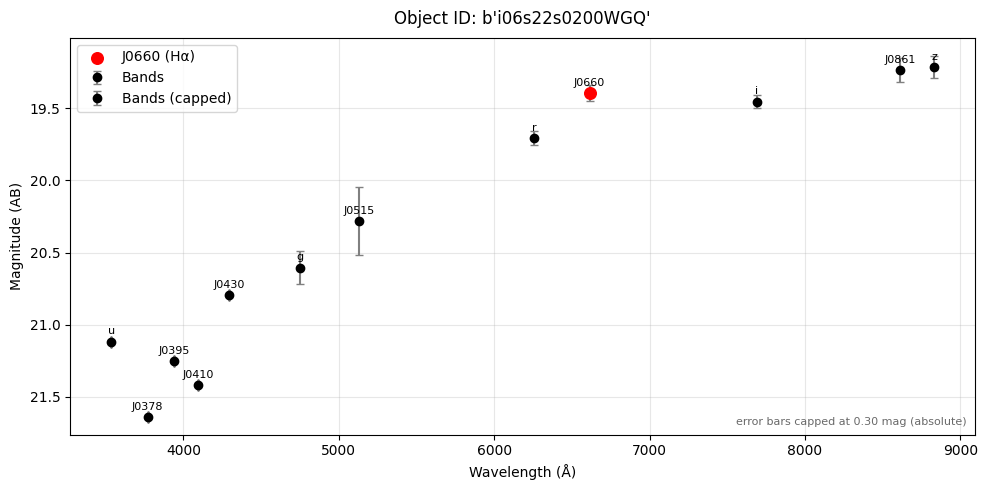

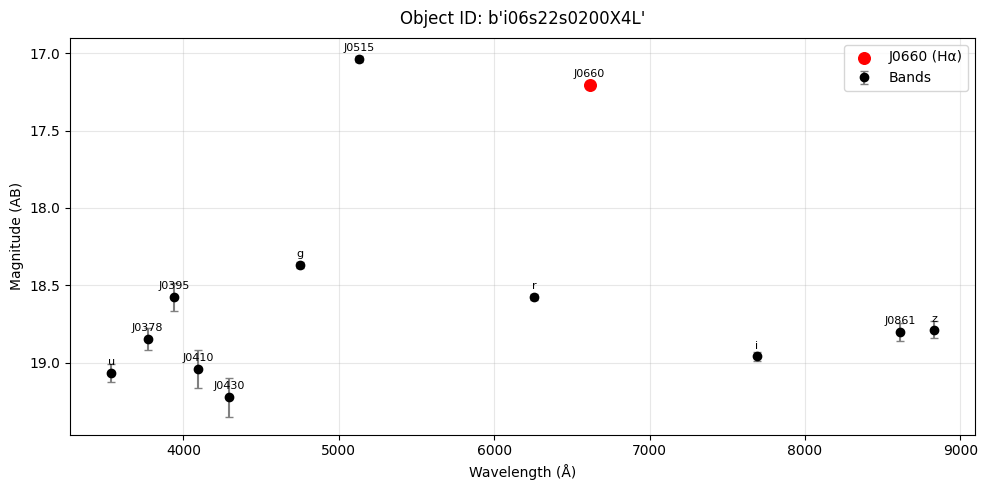

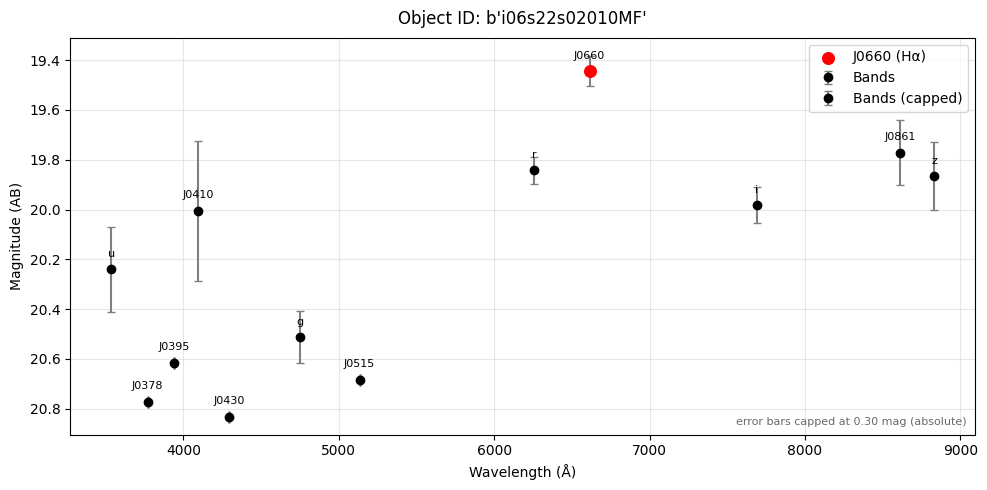

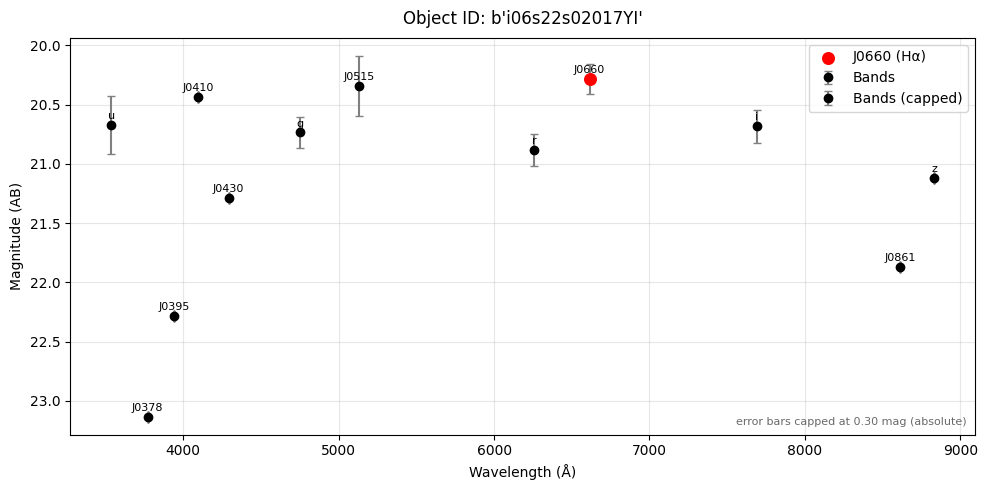

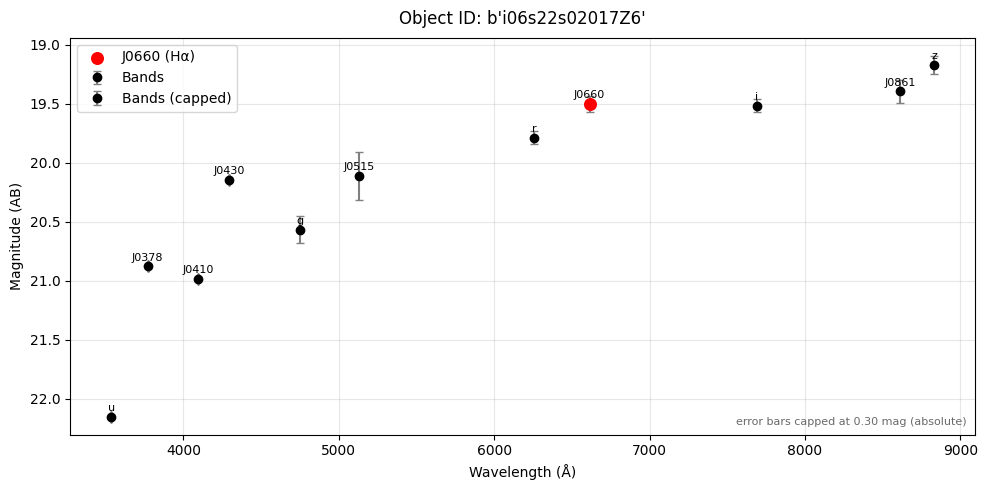

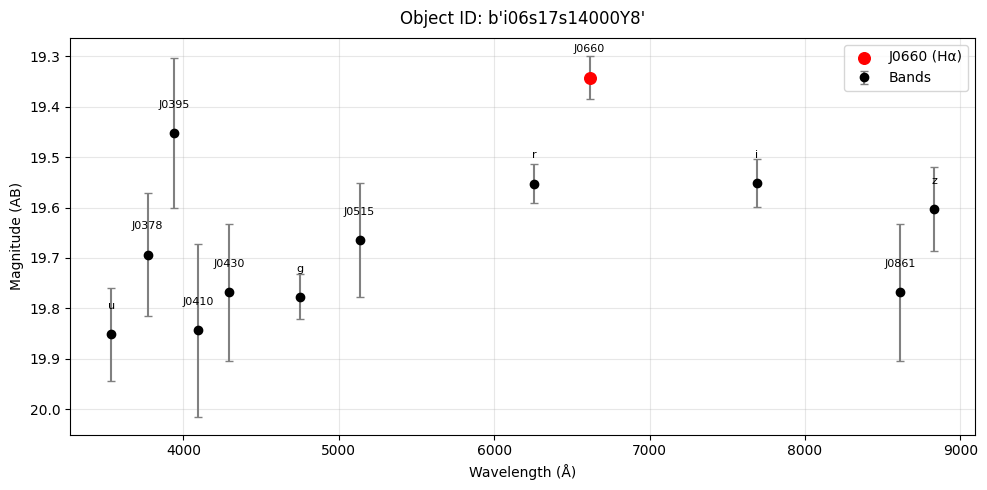

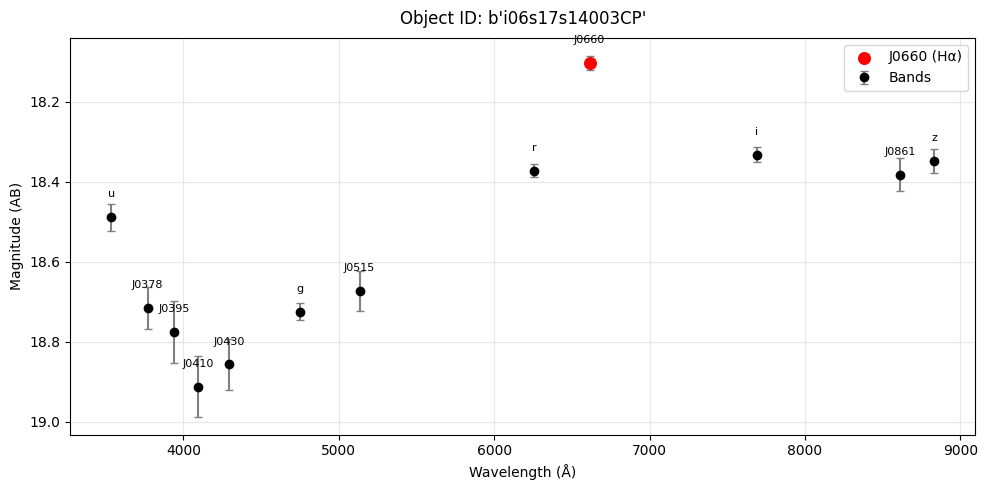

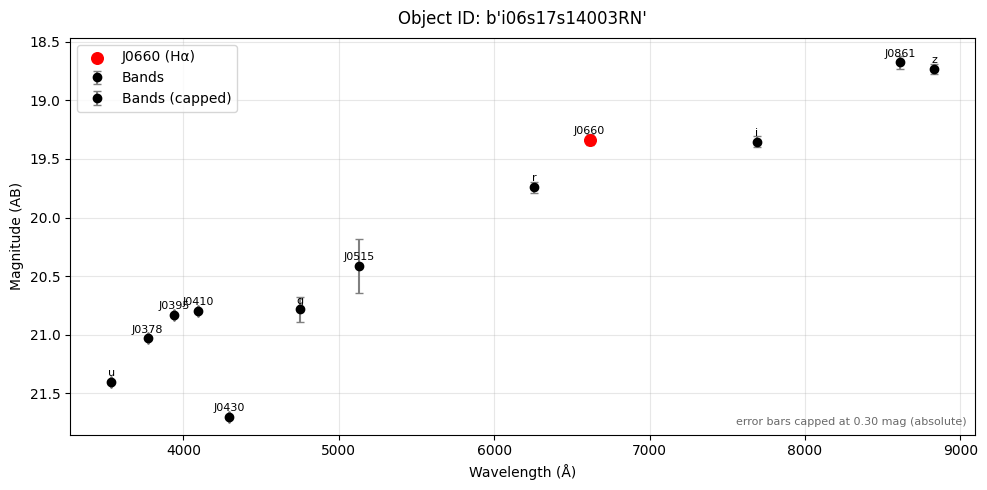

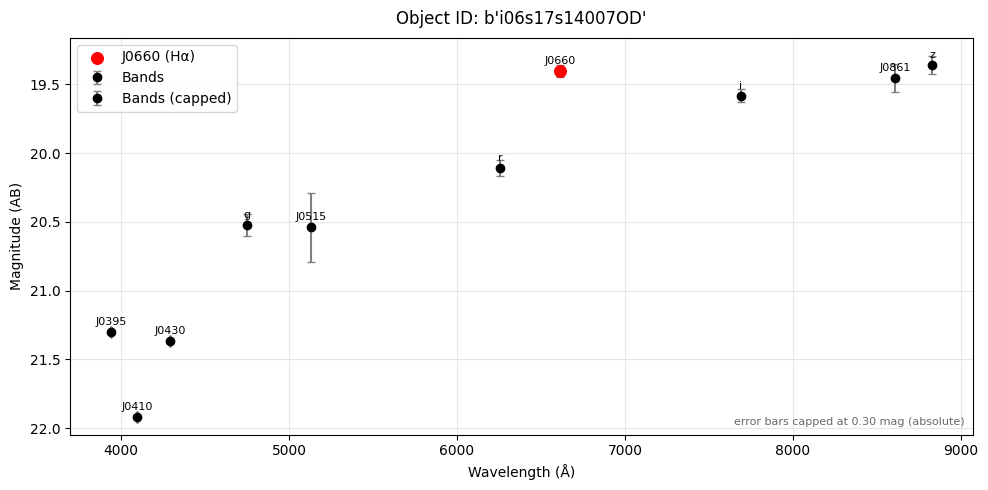

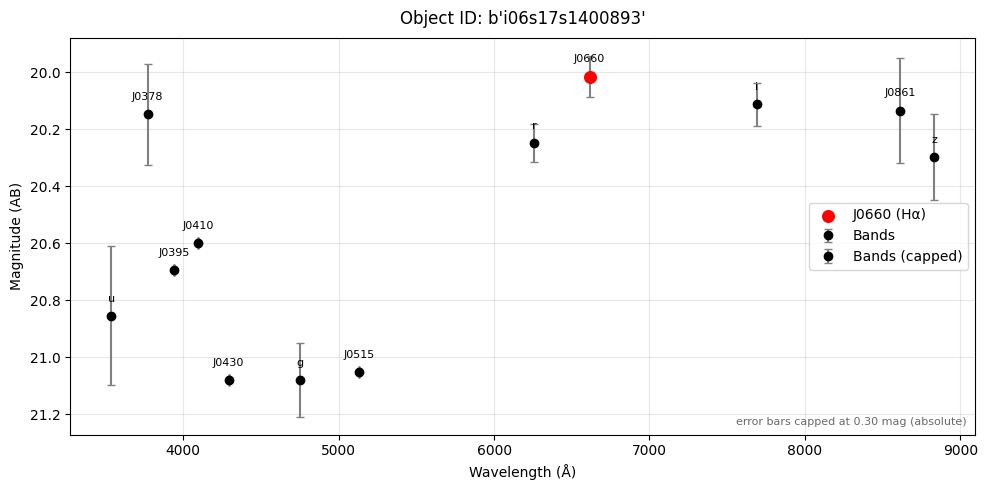

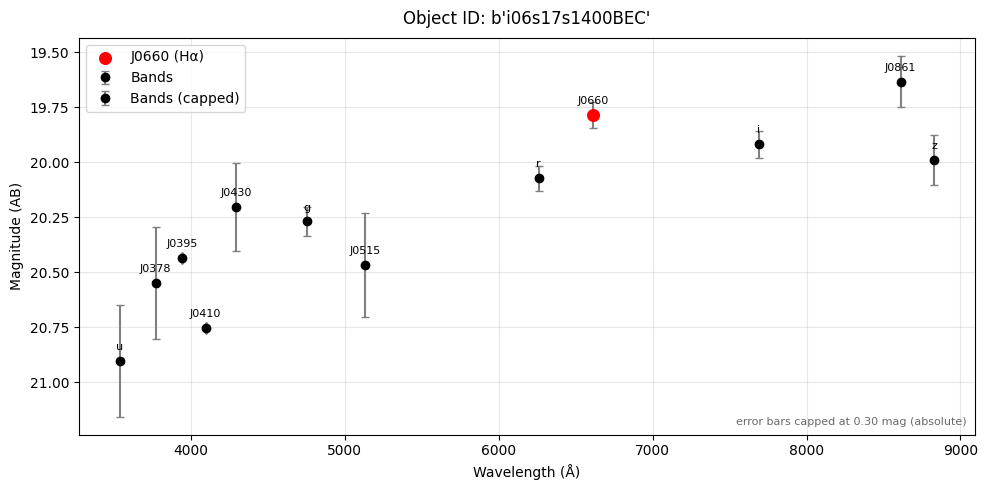

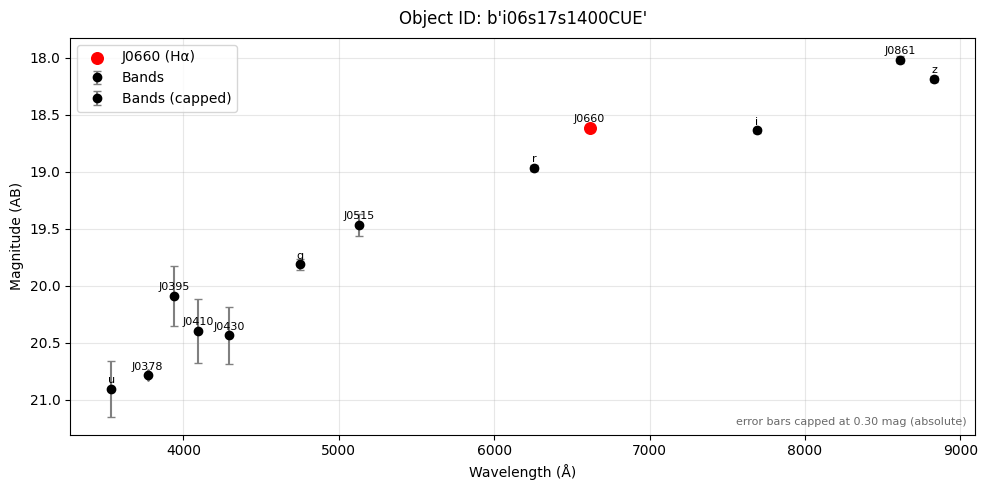

In [12]:
for i in range(20):
    plot_splus_sed_mag(emitters_df, emitters_df.index[i])

In [ ]:
emitters_df.to_csv("splus_halpha_emitters.csv", index=False)